## Principles and Applications of Data Science (Spring 2020)
## Term Project

### Student ID Number: 105590009 105590023 105590024 105590026
### Name: 張文有 芮嘉輝 黃泀翰 黃彥穎

### load libraries

In [6]:
import time
import warnings
import random
import pandas as pd
import datetime
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import numpy as np
import json
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import ast
from math import log
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [4]:
# ignore warnings
warnings.filterwarnings('ignore')

### 讀取資料

In [49]:
original_data = pd.read_csv("./Data/ted_main.csv")
original_data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


### Cleaning up the data

In [55]:
# 共有6個遺失的演講者職業，使用other填補
for index, row in original_data.iterrows():
    if pd.isnull(row['speaker_occupation']):
        original_data['speaker_occupation'][index] = 'Other'

#### related_talks

In [56]:
#切割related_talks欄位的資料
original_data['related_views'] = 0

for index, row in original_data.iterrows():
    vids = row['related_talks'].split(',')
    counter = 0
    total = 0
    for views in vids:
        if 'viewed_count' in views:
            view = views.split(':')
            # get rid of brackets and spaces
            view[1] = view[1].replace("]", "")
            view[1] = view[1].replace(" ", "")
            view[1] = view[1].replace("}", "")
            total+=int(view[1])
            counter+=1
    original_data['related_views'][index] = total/counter

In [57]:
#把published_date轉換成月份、星期幾...
#根據給定的時間戮，返回一個date物件
original_data['published_date'] = original_data['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
original_data['day'] = original_data['published_date'].apply(lambda x: x.weekday())
original_data['month'] = original_data['published_date'].apply(lambda x: x.month)
original_data['year'] = original_data['published_date'].apply(lambda x: x.year)
original_data['film_date'] = original_data['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
original_data['day_film'] = original_data['film_date'].apply(lambda x: x.weekday())
original_data['month_film'] = original_data['film_date'].apply(lambda x: x.month)
original_data['year_film'] = original_data['film_date'].apply(lambda x: x.year)

In [58]:
to_cat = {"day":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" },
          "month": {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 
                    9: "September", 10: "October", 11: "November", 12: "December"},
          "year":  {2006: "2006", 2007: "2007", 2008: "2008", 2009: "2009", 2010: "2010", 2011: "2011", 2012: "2012", 
                    2013: "2013", 2014: "2014", 2015: "2015", 2016: "2016", 2017: "2017"},
          "day_film":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" },
          "month_film": {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 
                    9: "September", 10: "October", 11: "November", 12: "December"},
          "year_film":  {2006: "2006", 2007: "2007", 2008: "2008", 2009: "2009", 2010: "2010", 2011: "2011", 2012: "2012", 
                    2013: "2013", 2014: "2014", 2015: "2015", 2016: "2016", 2017: "2017"}}

original_data.replace(to_cat, inplace=True)

In [11]:
#整理出唯一的名稱，統整出活動的名稱
print('Number of unique events: ',original_data['event'].unique().shape[0])
original_data['event'].unique()

Number of unique events:  355


array(['TED2006', 'TED2004', 'TED2005', 'TEDGlobal 2005', 'TEDSalon 2006',
       'TED2003', 'TED2007', 'TED2002', 'TEDGlobal 2007',
       'TEDSalon 2007 Hot Science', 'Skoll World Forum 2007', 'TED2008',
       'TED1984', 'TED1990', 'DLD 2007', 'EG 2007', 'TED1998',
       'LIFT 2007', 'TED Prize Wish', 'TEDSalon 2009 Compassion',
       'Chautauqua Institution', 'Serious Play 2008', 'Taste3 2008',
       'TED2001', 'TED in the Field', 'TED2009', 'EG 2008',
       'Elizabeth G. Anderson School', 'TEDxUSC', 'TED@State',
       'TEDGlobal 2009', 'TEDxKC', 'TEDIndia 2009',
       'TEDSalon London 2009', 'Justice with Michael Sandel',
       'Business Innovation Factory', 'TEDxTC',
       'Carnegie Mellon University', 'Stanford University',
       'AORN Congress', 'University of California', 'TEDMED 2009',
       'Royal Institution', 'Bowery Poetry Club', 'TEDxSMU',
       'Harvard University', 'TEDxBoston 2009', 'TEDxBerlin', 'TED2010',
       'TEDxAmsterdam', 'World Science Festival', 

In [59]:
# initialise all values as 'Other' to assign this category
# to all entries that don't fit into the chosen categories
#由於活動名稱相似，我們將相似的名稱統整在一起
original_data['event_category'] = 'Other'

for i in range(len(original_data)):
    if original_data['event'][i][0:5]=='TED20':
        original_data['event_category'][i] = 'TED2000s'
    elif original_data['event'][i][0:5]=='TED19':
        original_data['event_category'][i] = 'TED1900s'
    elif original_data['event'][i][0:4]=='TEDx':
        original_data['event_category'][i] = "TEDx"
    elif original_data['event'][i][0:7]=='TED@BCG':
        original_data['event_category'][i] = 'TED@BCG'
    elif original_data['event'][i][0:4]=='TED@':
        original_data['event_category'][i] = "TED@"
    elif original_data['event'][i][0:8]=='TEDSalon':
        original_data['event_category'][i] = "TEDSalon"
    elif original_data['event'][i][0:9]=='TEDGlobal':
        original_data['event_category'][i] = 'TEDGlobal'
    elif original_data['event'][i][0:8]=='TEDWomen':
        original_data['event_category'][i] = 'TEDWomen'
    elif original_data['event'][i][0:6]=='TEDMED':
        original_data['event_category'][i] = 'TEDMED'
    elif original_data['event'][i][0:3]=='TED':
        original_data['event_category'][i] = 'TEDOther'

In [60]:
original_data['event_category'].unique()

array(['TED2000s', 'TEDGlobal', 'TEDSalon', 'Other', 'TED1900s',
       'TEDOther', 'TEDx', 'TED@', 'TEDMED', 'TEDWomen', 'TED@BCG'],
      dtype=object)

#### tags

In [61]:
destring = []
for number in range(len(original_data)):
    #Remove string
    destring.append(ast.literal_eval(original_data['tags'][number]))
original_data['Tags'] = pd.Series(destring)

In [62]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)

In [63]:
#找出tags的所有標籤
listed = [item for sublist in destring for item in sublist]
listed = pd.Series(listed)
lists = list(listed.unique())
lists2 = [ x for x in lists if " " not in x ]
lists2 = [ x for x in lists2 if "-" not in x ]

In [64]:
lists2.remove('archaeology')
lists2.remove('TEDYouth')
lists2.remove('deextinction')
lists2.remove('blockchain')
lists2.remove('TEDNYC')

Text(0.5, 1.0, 'Tag Clusters')

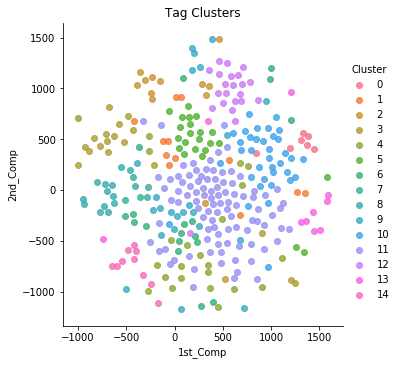

In [18]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

labels = []
tokens = []

for word in lists2:
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=105000, random_state=17,learning_rate=5500)
new_values = tsne_model.fit_transform(tokens)

kmeans = KMeans(n_clusters=15,n_init=200)
kmeans.fit(tokens)
clusters = kmeans.predict(tokens)

df_tsne = pd.DataFrame(new_values, columns=['1st_Comp', '2nd_Comp'])
df_tsne['Cluster'] = clusters

sns.lmplot(x='1st_Comp', y='2nd_Comp', data=df_tsne, hue='Cluster', fit_reg=False)
plt.title("Tag Clusters")

In [65]:
convert = {labels[word]: clusters[word] for word in range(len(labels))}

In [66]:
comp = pd.DataFrame(labels)
comp['cluster'] = clusters

In [67]:
comp_conver = {0:'Organizing/Perceiving Information',1:'animals/organisms',2:'exploration',3:'Scientific Fields',
              4:'media/entertainment',5:'arts/creativity',6:'Epidemics',7:'Humanity/Progress',8:'Vices/Prejudices',
              9:'robots/prosthetics',10:'music',11:'philanthropy/religion',12:'Middle East',13:'Global issues',
              14:'Outer-Space',15:'NA'}

In [68]:
comp['group'] = 'None'
for ii in range(len(comp)):
    comp['group'][ii] = comp_conver[comp['cluster'][ii]]
    
unique = comp['group'].unique()

In [69]:
for group in unique:
    original_data[group+'_tag'] = 0
    for item in range(len(original_data['Tags'])):
        for i in original_data['Tags'][item]:
            try:
                clust = convert[i]
            except KeyError:
                clust = 15
            grouping = comp_conver[clust]
            if grouping == group:
                original_data[group+'_tag'][item] = 1

In [70]:
original_data.filter(like='_tag', axis=1).head()

,philanthropy/religion_tag,music_tag,arts/creativity_tag,robots/prosthetics_tag,Middle East_tag,Epidemics_tag,media/entertainment_tag,Global issues_tag,Humanity/Progress_tag,Outer-Space_tag,animals/organisms_tag,Scientific Fields_tag,Organizing/Perceiving Information_tag,exploration_tag,Vices/Prejudices_tag
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0


### Visualization

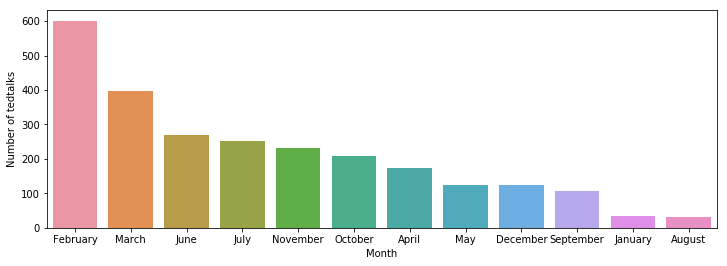

In [72]:
#計算哪個月份最多演講
month_cnt_df = pd.DataFrame(original_data['month_film'].value_counts()).reset_index()
month_cnt_df.columns = ['Month', 'Number of tedtalks']

fig = plt.figure(figsize=(12,4))
sns.barplot(x = 'Month', y = 'Number of tedtalks', data = month_cnt_df)

In [73]:
original_data.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'related_views', 'day', 'month', 'year', 'day_film',
       'month_film', 'year_film', 'event_category', 'Tags',
       'philanthropy/religion_tag', 'music_tag', 'arts/creativity_tag',
       'robots/prosthetics_tag', 'Middle East_tag', 'Epidemics_tag',
       'media/entertainment_tag', 'Global issues_tag', 'Humanity/Progress_tag',
       'Outer-Space_tag', 'animals/organisms_tag', 'Scientific Fields_tag',
       'Organizing/Perceiving Information_tag', 'exploration_tag',
       'Vices/Prejudices_tag'],
      dtype='object')

In [74]:
vis = original_data.filter(like='_tag', axis=1)
vis['views'] =original_data['views']
# vis.head()

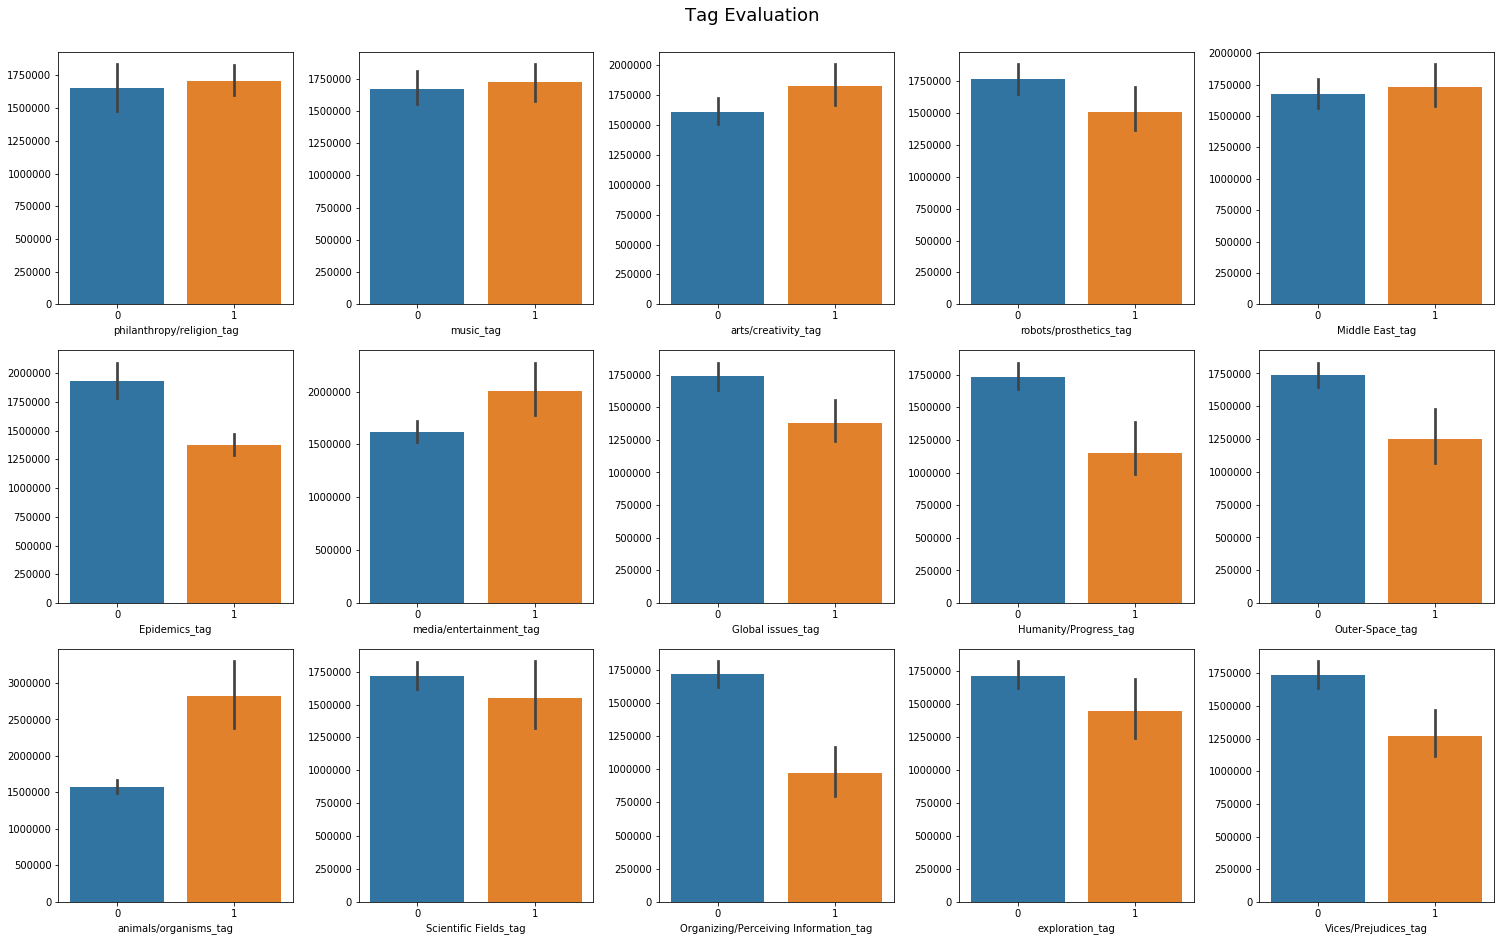

In [75]:
#觀察tag與views的關係
fig = plt.figure(figsize=(21,14))
#Create a barplot for each tag showing the mean number of views
for i in np.arange(15):
    ax = fig.add_subplot(3,5,i+1)
    sns.barplot(x=vis.iloc[:,i], y=vis['views'])
    plt.ylabel('',)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle("Tag Evaluation", fontsize = 18)
plt.show()

In [76]:
#觀察場次類別與views的關係
event_unique = original_data['event_category'].unique()
for group in event_unique:
    original_data[group+'_unique'] = 0
    for item in range(len(original_data['event_category'])):
        if group == original_data['event_category'][item] :
            original_data[group+'_unique'][item] = 1

In [77]:
category = original_data.filter(like='_unique', axis=1)
category['views'] =original_data['views']
# category.head()

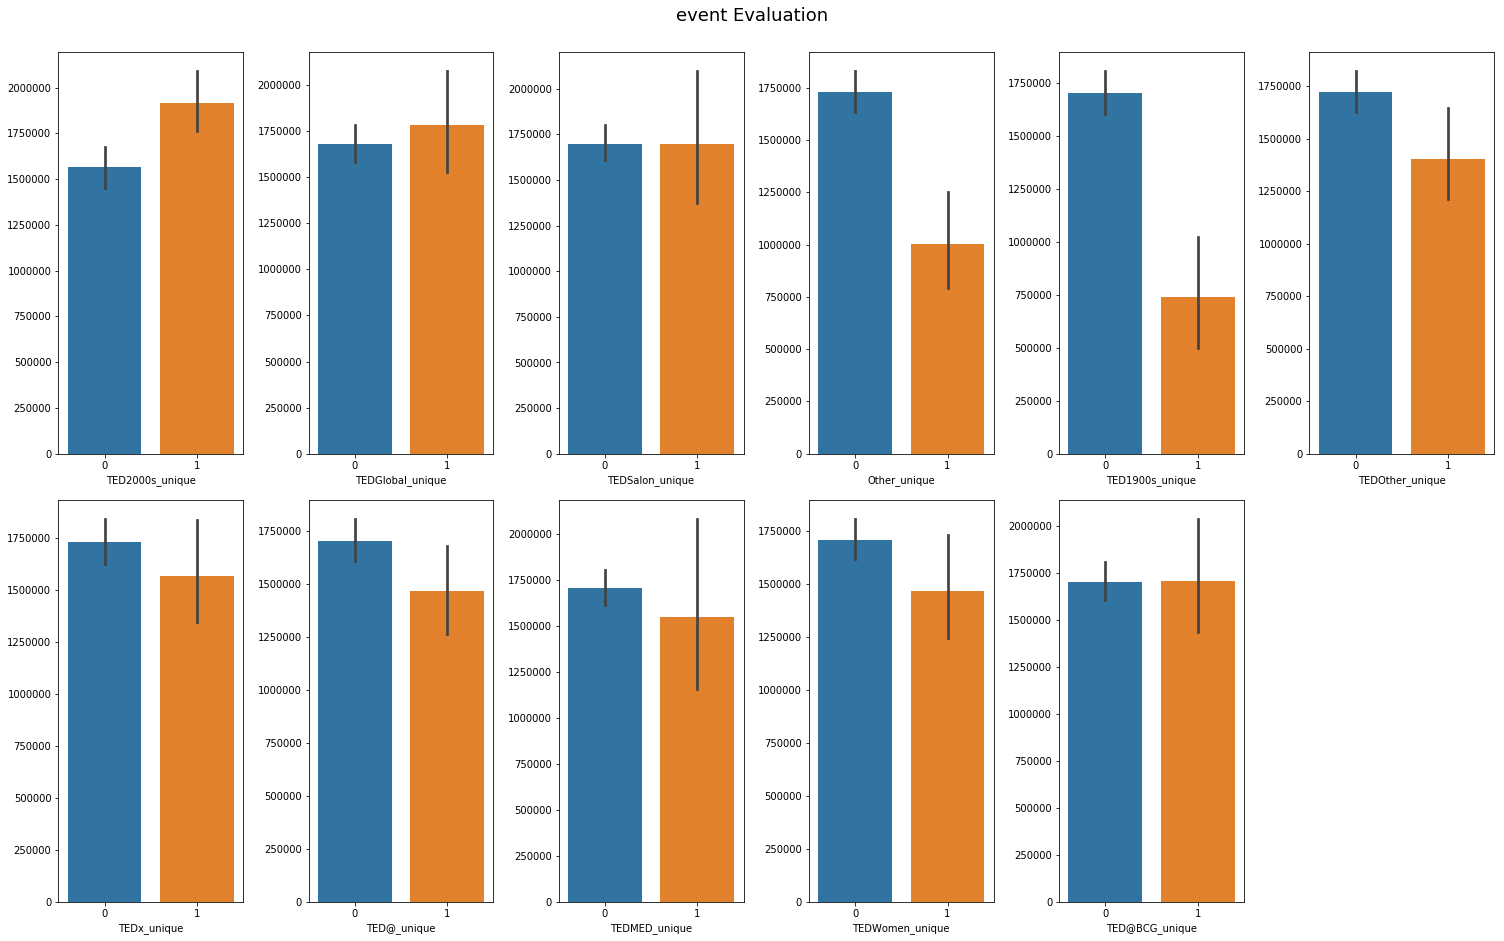

In [78]:
fig = plt.figure(figsize=(21,14))
#fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(6, 6))
#Create a barplot for each tag showing the mean number of views
for i in np.arange(11):
    ax = fig.add_subplot(2,6,i+1)
    sns.barplot(x=category.iloc[:,i], y=category['views'])
    plt.ylabel('',)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle("event Evaluation", fontsize = 18)
plt.show()

In [79]:
day_unique = original_data['day'].unique()
for group in day_unique:
    original_data[group+'_unique'] = 0
    for item in range(len(original_data['day'])):
        if group == original_data['day'][item]:
            original_data[group+'_unique'][item] = 1

In [80]:
day = original_data.filter(like='day_unique', axis=1)
day['views'] =original_data['views']
# day.head()

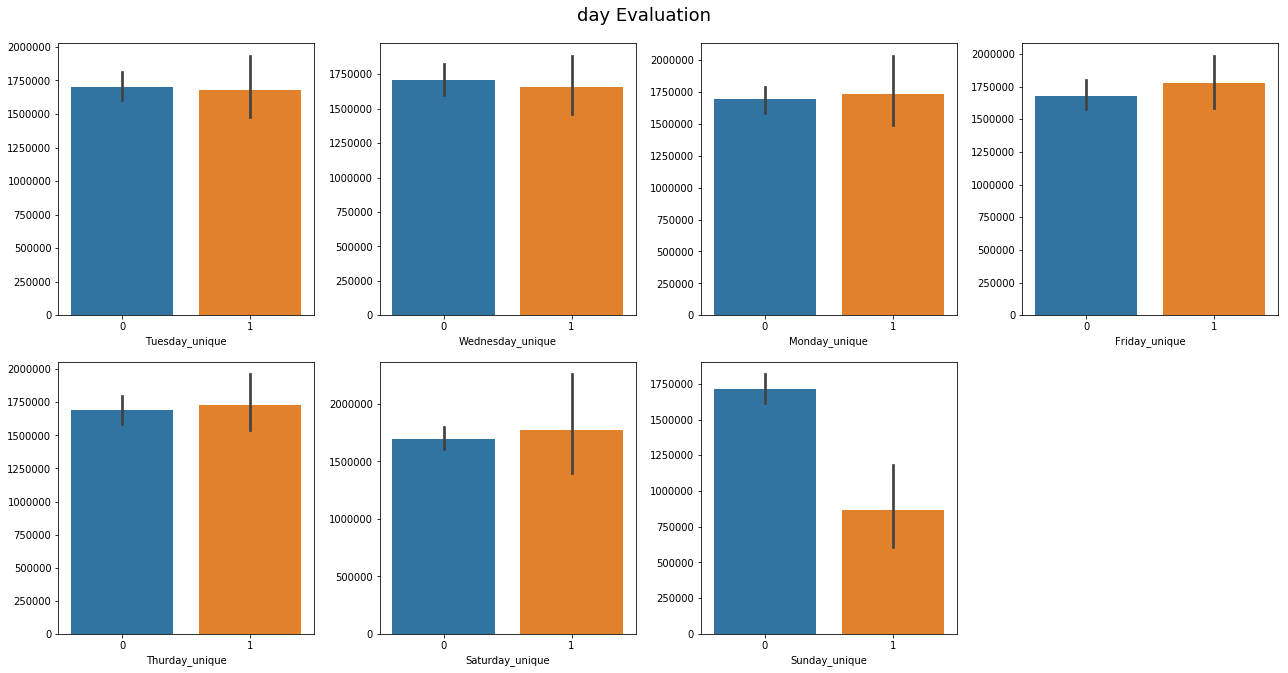

In [81]:
fig = plt.figure(figsize=(18,10))
#Create a barplot for each tag showing the mean number of views
for i in np.arange(7):
    ax = fig.add_subplot(2,4,i+1)
    sns.barplot(x=day.iloc[:,i], y=day['views'])
    plt.ylabel('',)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle("day Evaluation", fontsize = 18)
plt.show()

### Final touches on the dataset

In [123]:
views = original_data['views']
comments = original_data['comments']
temp_data = original_data.drop(['comments', 'description', 'event','film_date', 'main_speaker', 'name', 'ratings', 
           'related_talks', 'tags', 'title', 'url','year_film','day_film', 'views', 'speaker_occupation', 'Tags',], 1)

In [124]:
test_data = pd.read_csv("./Data/ted_main.csv")
published_date = test_data['published_date']
temp_data['published_date'] =published_date

In [125]:
data = pd.get_dummies(temp_data)
# data.columns

#### 挑選特徵

In [128]:
selected_features = [['languages','related_views','duration','published_date'], ['Vices/Prejudices_tag', 'Outer-Space_tag', 
                     'exploration_tag', 'Scientific Fields_tag', 'Organizing/Perceiving Information_tag', 
                     'media/entertainment_tag', 'robots/prosthetics_tag', 'Global issues_tag', 'Humanity/Progress_tag', 
                     'music_tag', 'animals/organisms_tag', 'Epidemics_tag', 'Middle East_tag', 'arts/creativity_tag', 
                     'philanthropy/religion_tag', 'day_Monday', 'day_Tuesday', 'day_Saturday', 'day_Thurday', 'day_Friday'
                     ,'day_Wednesday' ,'day_Sunday']]

### 將資料標準化

In [130]:
sc = StandardScaler()
sc.fit(data[selected_features[0]])
final_data = sc.transform(data[selected_features[0]])

In [131]:
final_data = np.hstack((final_data, data[selected_features[1]]))

In [154]:
final_data[0].size

26

In [132]:
# 將views取log
log_views = views.apply(lambda x: log(x))

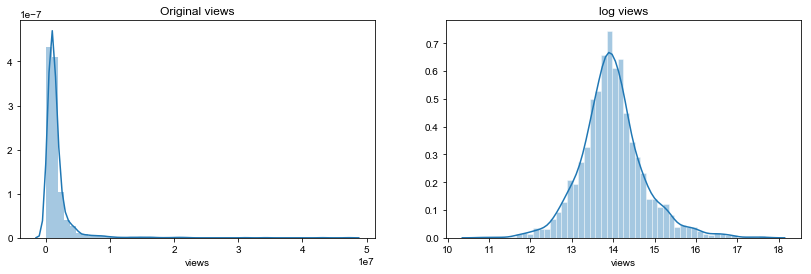

In [133]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('Original views')
sns.distplot(views)

plt.subplot(1, 2, 2)
sns.set_style('dark')
plt.title('log views')
sns.distplot(log_views)

In [134]:
# 將演講依照觀看次數分群
def groupView(view, mean, std):
    if view >= mean + 3*std:
        return 1
    elif view >= mean + 2 *std:
        return 2
    elif view >= mean + std:
        return 3
    elif view >= mean:
        return 4
    elif view < mean:
        return 5
    return 0

In [135]:
target = log_views.apply(lambda x: groupView(x, log_views.mean(), log_views.std()))

### Machine Learning

#### Random forest regressor

In [136]:
# 將資料分為訓練及測試
X_train, X_test, y_train, y_test = train_test_split(final_data, views, test_size=0.3, random_state=42)

In [ ]:
rf = RandomForestRegressor(criterion='mae',max_depth=15, max_features=15, n_estimators=500, min_samples_leaf=2, min_samples_split=2,
                          random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))
print('Views mean: {:0.2f}'.format(views.mean()))
print('Views std: {:0.2f}'.format(views.std()))

###  VotingClassifier: Different Feature Sets

In [138]:
# custom transformer for sklearn pipeline
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        col_list = []
        for c in self.cols:
            col_list.append(X[:, c:c+1])
        return np.concatenate(col_list, axis=1)

    def fit(self, X, y=None):
        return self

In [139]:
X_train, X_test, y_train, y_test = train_test_split(final_data, target, test_size=0.3, random_state=42)

In [140]:
# fit clf1 with df1
pipe1 = Pipeline([
    ('col_extract', ColumnExtractor( cols=range(0,3) )), # selecting features 0 to 3 (df1) to be used with LR (clf1)
    ('clf', SVC(kernel='poly', probability=True, random_state=42))
    ])
pipe1.fit(X_train, y_train) # sanity check
pipe1.score(X_test, y_test) # sanity check

0.5947712418300654

In [141]:
# fit clf2 with df2
pipe2 = Pipeline([
    ('col_extract', ColumnExtractor( cols=range(4,18) )), # selecting features 4 to 25 (df2) to be used with SVC (clf2)
    ('clf', SVC(kernel='poly', probability=True, random_state=42))
    ])
pipe2.fit(X_train, y_train) # sanity check
pipe2.score(X_test, y_test) # sanity check

0.5437908496732026

In [142]:
# fit clf3 with df3
pipe3 = Pipeline([
    ('col_extract', ColumnExtractor( cols=range(19,25) )), # selecting features 4 to 25 (df2) to be used with SVC (clf2)
    ('clf', SVC(kernel='poly', probability=True, random_state=42))
    ])
pipe3.fit(X_train, y_train) # sanity check
pipe3.score(X_test, y_test) # sanity check

0.5699346405228758

In [143]:
vc = VotingClassifier(estimators=[('df1-clf1', pipe1), ('df2-clf2', pipe2), ('df3-clf3', pipe3)], voting='soft', weights= [1, 1, 1])
vc.fit(X_train, y_train)
vc.score(X_test, y_test)

0.5712418300653594

In [144]:
confusion_matrix(y_test.values, vc.predict(X_test))

array([[  0,   0,   0,   3,   4],
       [  0,   0,   0,   8,  13],
       [  0,   0,   0,   5,  57],
       [  0,   0,   0,   6, 233],
       [  0,   0,   0,   5, 431]], dtype=int64)

In [145]:
svc = SVC(kernel='poly', probability=True, random_state=42)
svc.fit(X_train, y_train)
accuracy_score(y_test.values, svc.predict(X_test))

0.6392156862745098

In [146]:
confusion_matrix(y_test.values, svc.predict(X_test))

array([[  0,   1,   4,   2,   0],
       [  2,   2,  10,   4,   3],
       [  2,   2,   8,  42,   8],
       [  0,   2,   7, 125, 105],
       [  0,   2,   7,  73, 354]], dtype=int64)